In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

![](https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg)

Download the SDSS quasars data

In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

data = data['redshift']

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [3]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

# Code

Text(0, 0.5, 'pdf')

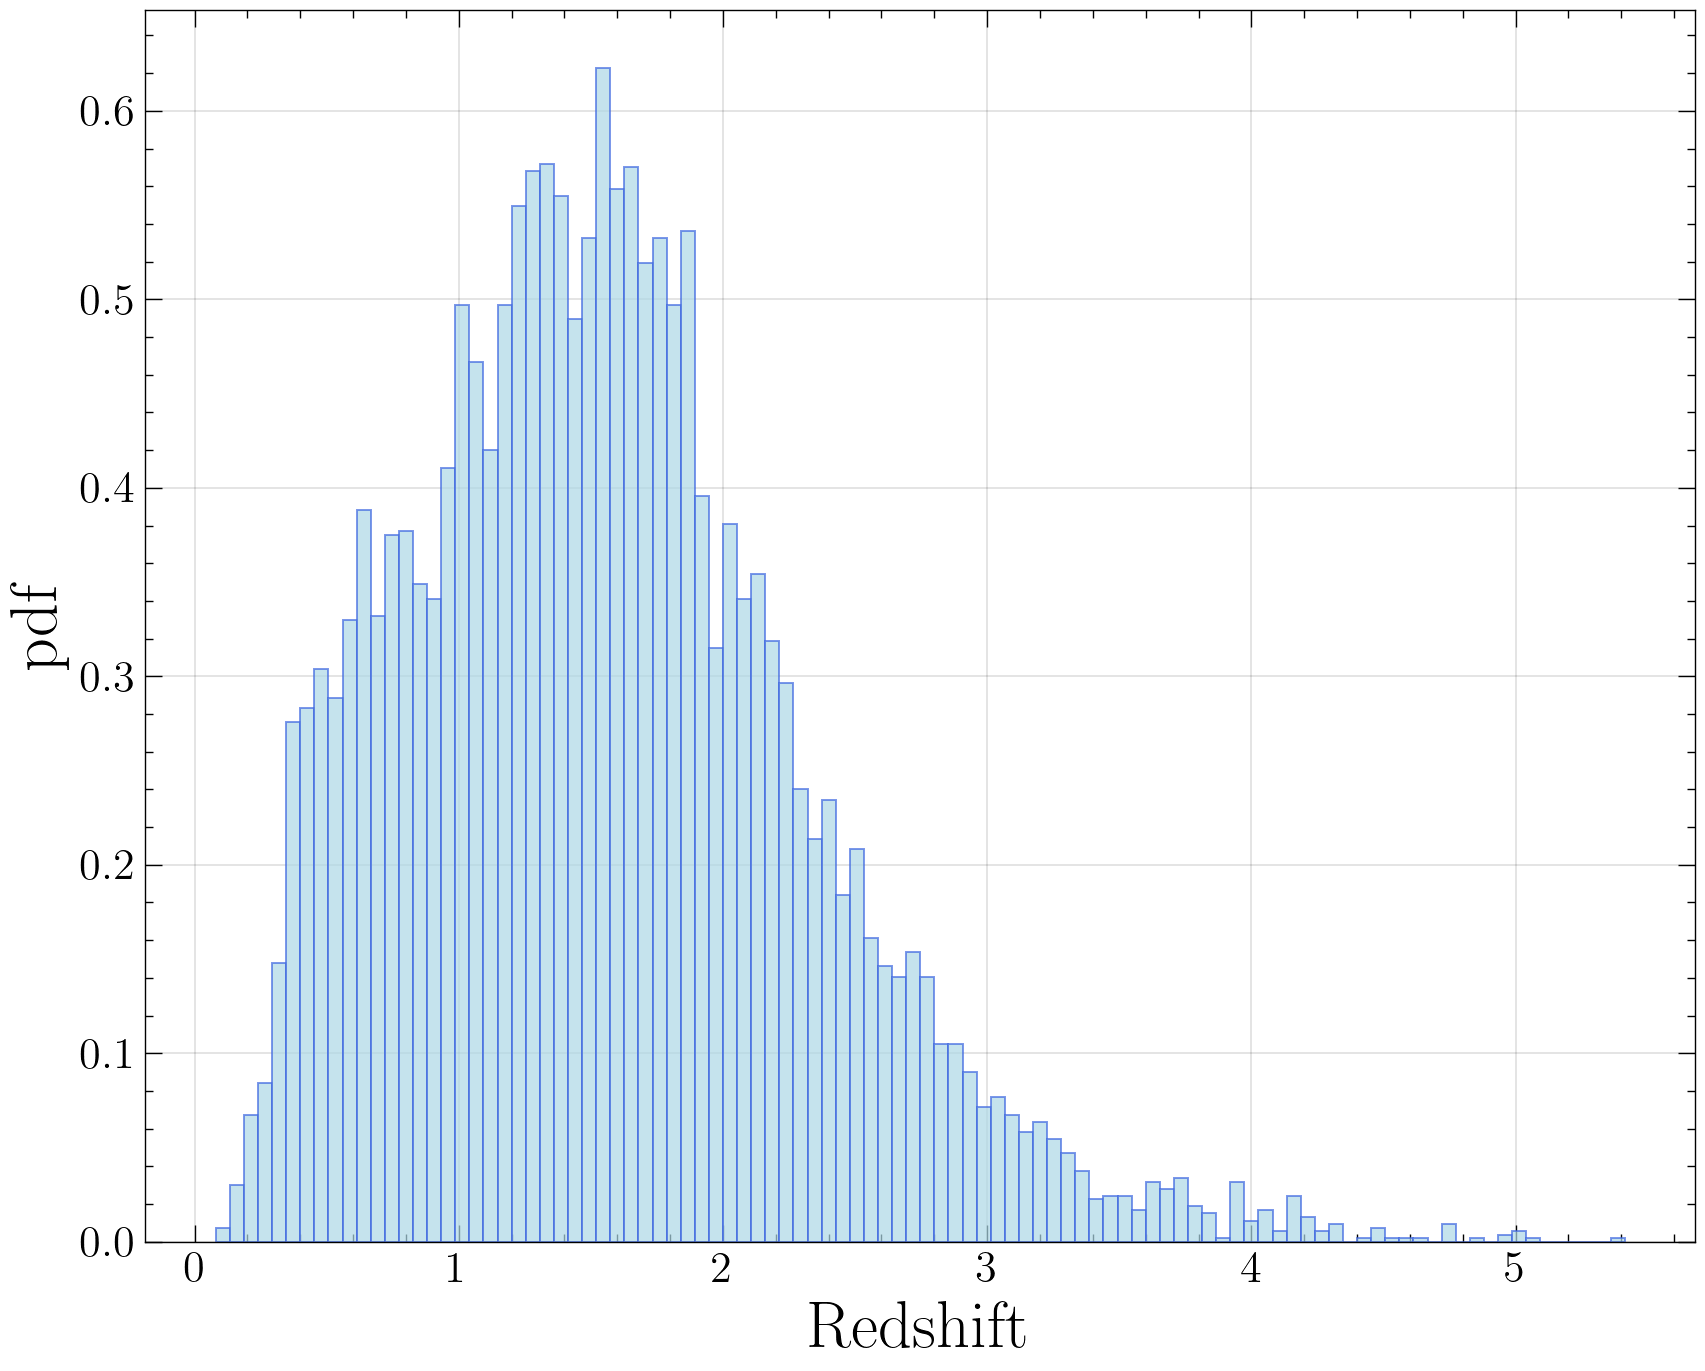

In [4]:
pdf_values, bins = plt.hist(data, bins=100, density=True, color='lightblue', edgecolor='royalblue', alpha=0.7, linewidth=0.7)[:-1]
plt.xlabel('Redshift')
plt.ylabel('pdf')

## 1) Rejection Sampling

Identify the boundaries

In [5]:
x_min = np.min(data)
x_max = np.max(data)
y_max = np.max(pdf_values)
print('x_min =', x_min)
print('x_max =', x_max)
print('y_max =', y_max)

x_min = 0.0802
x_max = 5.4135
y_max = 0.6225033764724289


Apply the rejection sampling technique

In [6]:
N = int(1e6)

hist_pdf = scipy.stats.rv_histogram(np.histogram(data, bins=100))

x = np.random.uniform(x_min, x_max, N)
y = np.random.uniform(0, y_max, N)
  
new_data_rejection = x[y <= hist_pdf.pdf(x)]
    
print(len(new_data_rejection))

300650


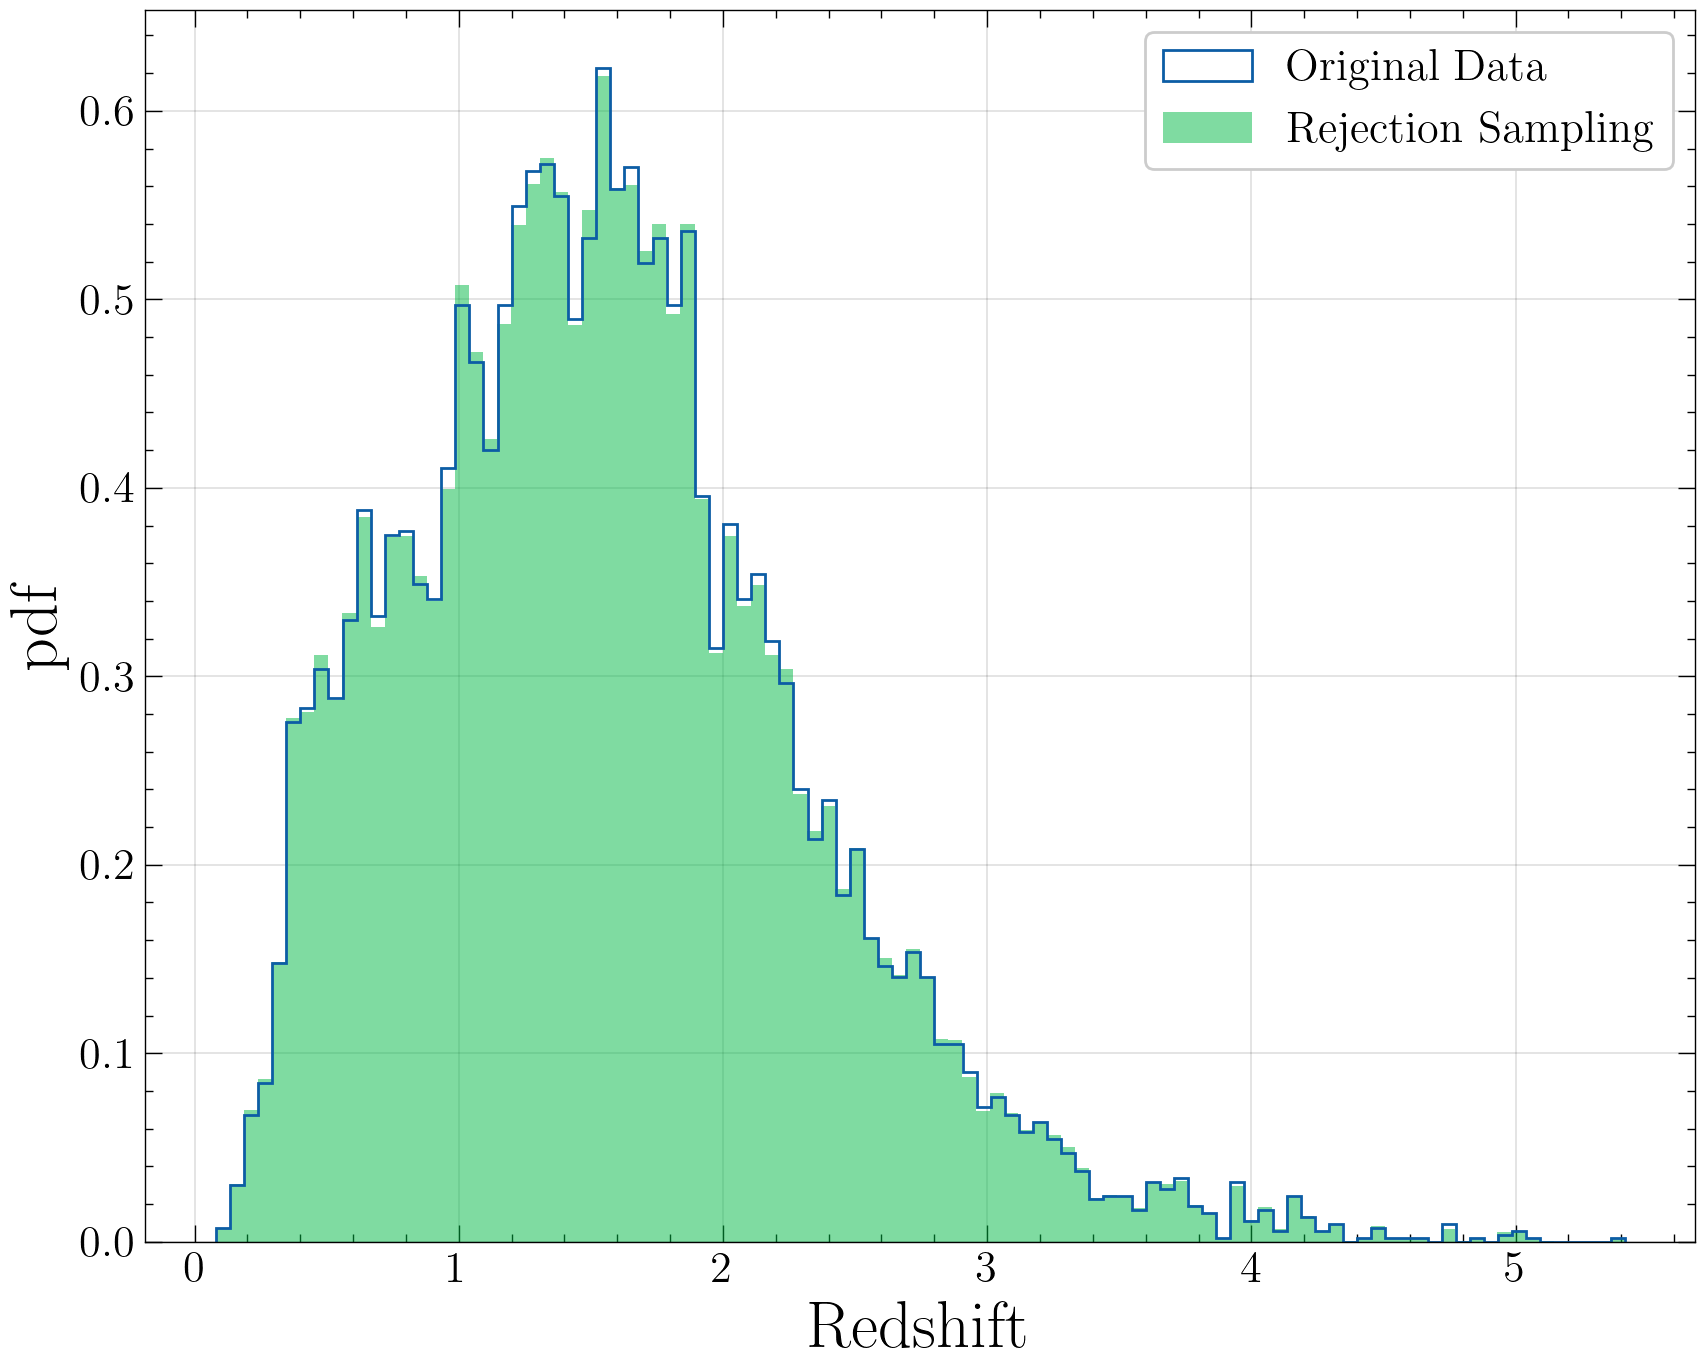

In [7]:
plt.hist(data, bins=100, density=True, histtype='step', label='Original Data');
plt.hist(new_data_rejection, bins=100, density=True, alpha=0.5, label='Rejection Sampling');
plt.xlabel('Redshift')
plt.ylabel('pdf')
plt.legend()

## 2) Inverse Transform Sampling

Reconstruct the CDF from the data and interpolate it

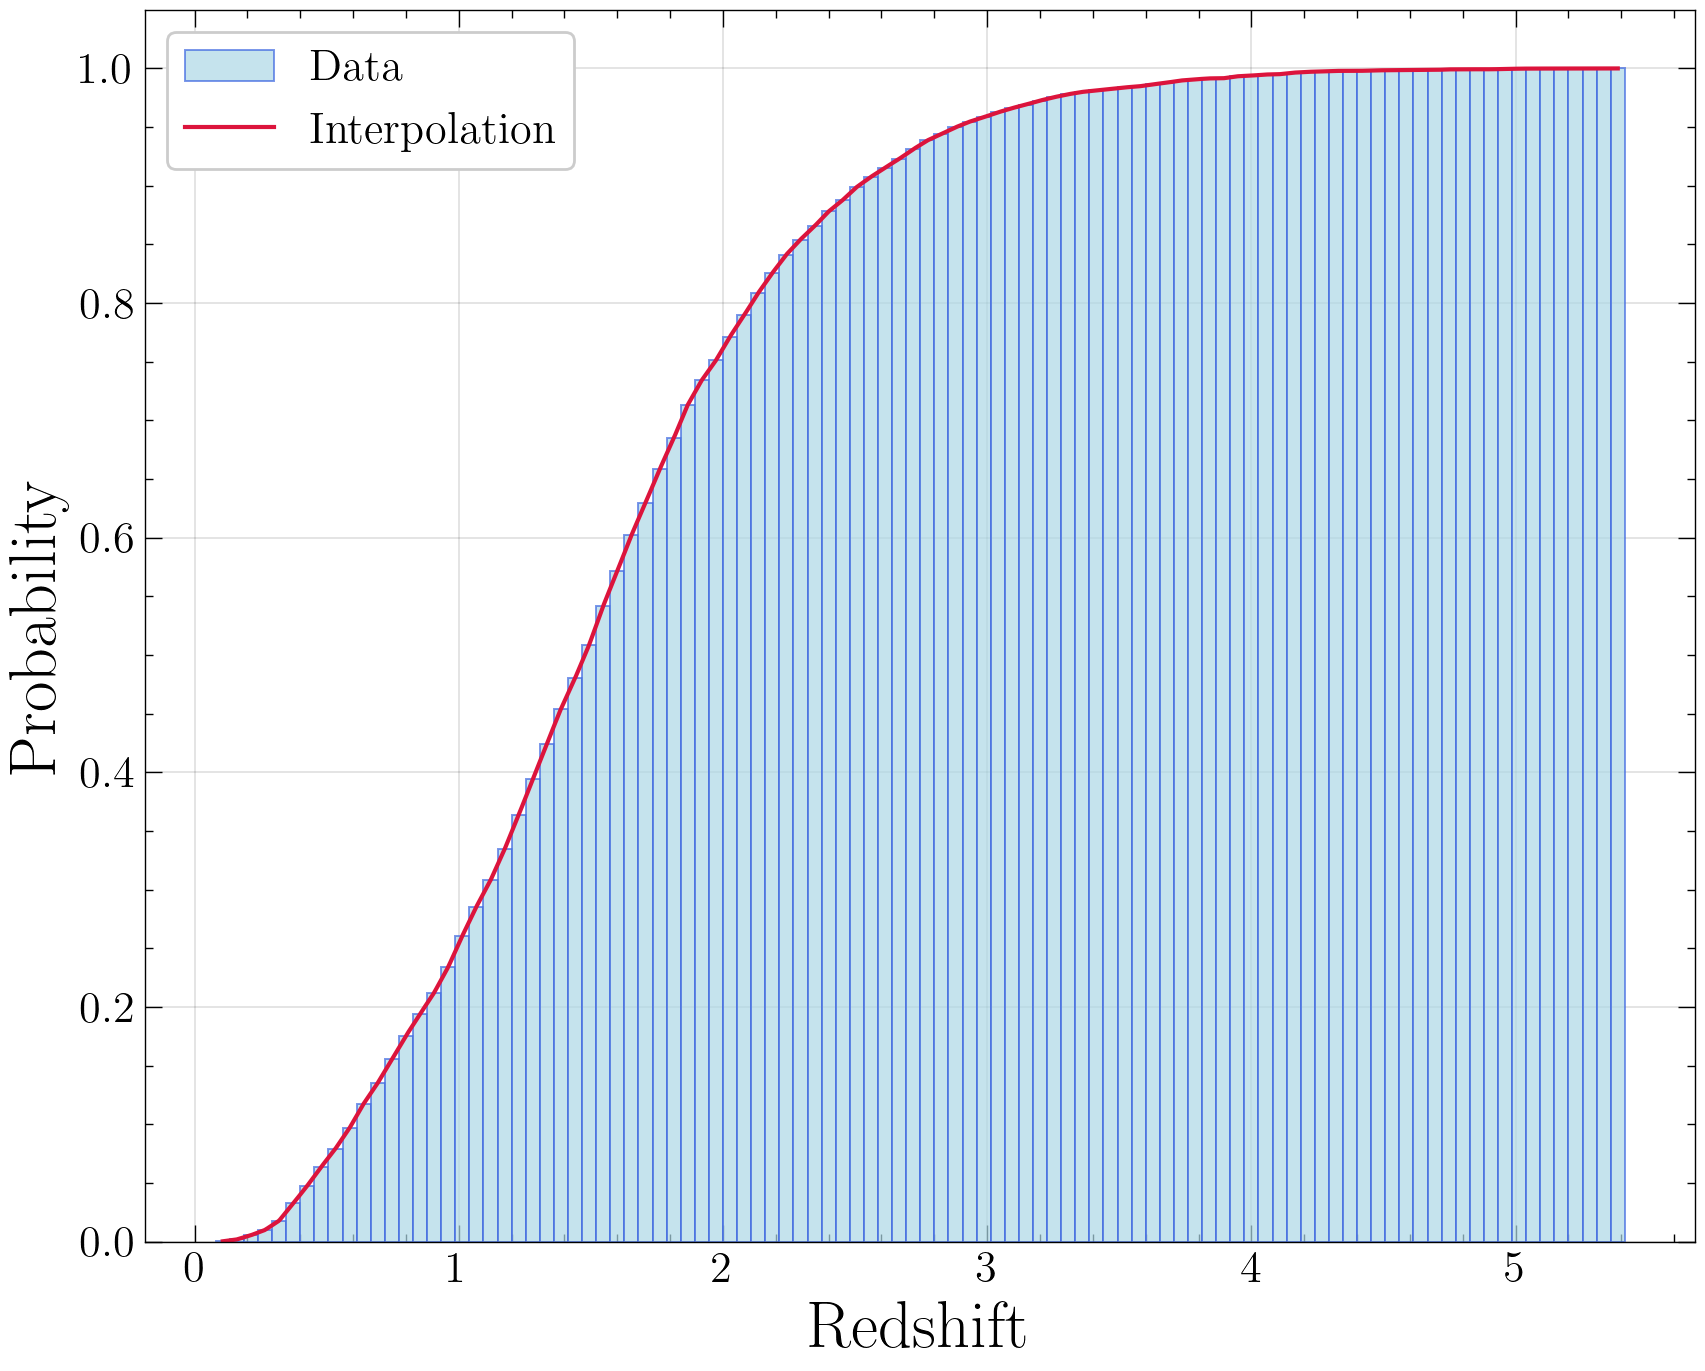

In [8]:
pdf_values, bins = plt.hist(data, bins=100, cumulative=True, density=True, 
                            color='lightblue', edgecolor='royalblue', alpha=0.7, linewidth=0.7, label='Data')[:-1]
plt.xlabel('Redshift')
plt.ylabel('Probability')

bin_centres = bins[:-1] + np.diff(bins)/2

CDF = scipy.interpolate.interp1d(x=bin_centres, y=pdf_values)
x_dense = np.linspace(np.min(bin_centres), np.max(bin_centres), 1000)
plt.plot(x_dense, CDF(x_dense), color='crimson', label='Interpolation')

plt.legend()

Interpolate the inverse CDF

x_min = 0.0004
x_max = 0.9999999999999999


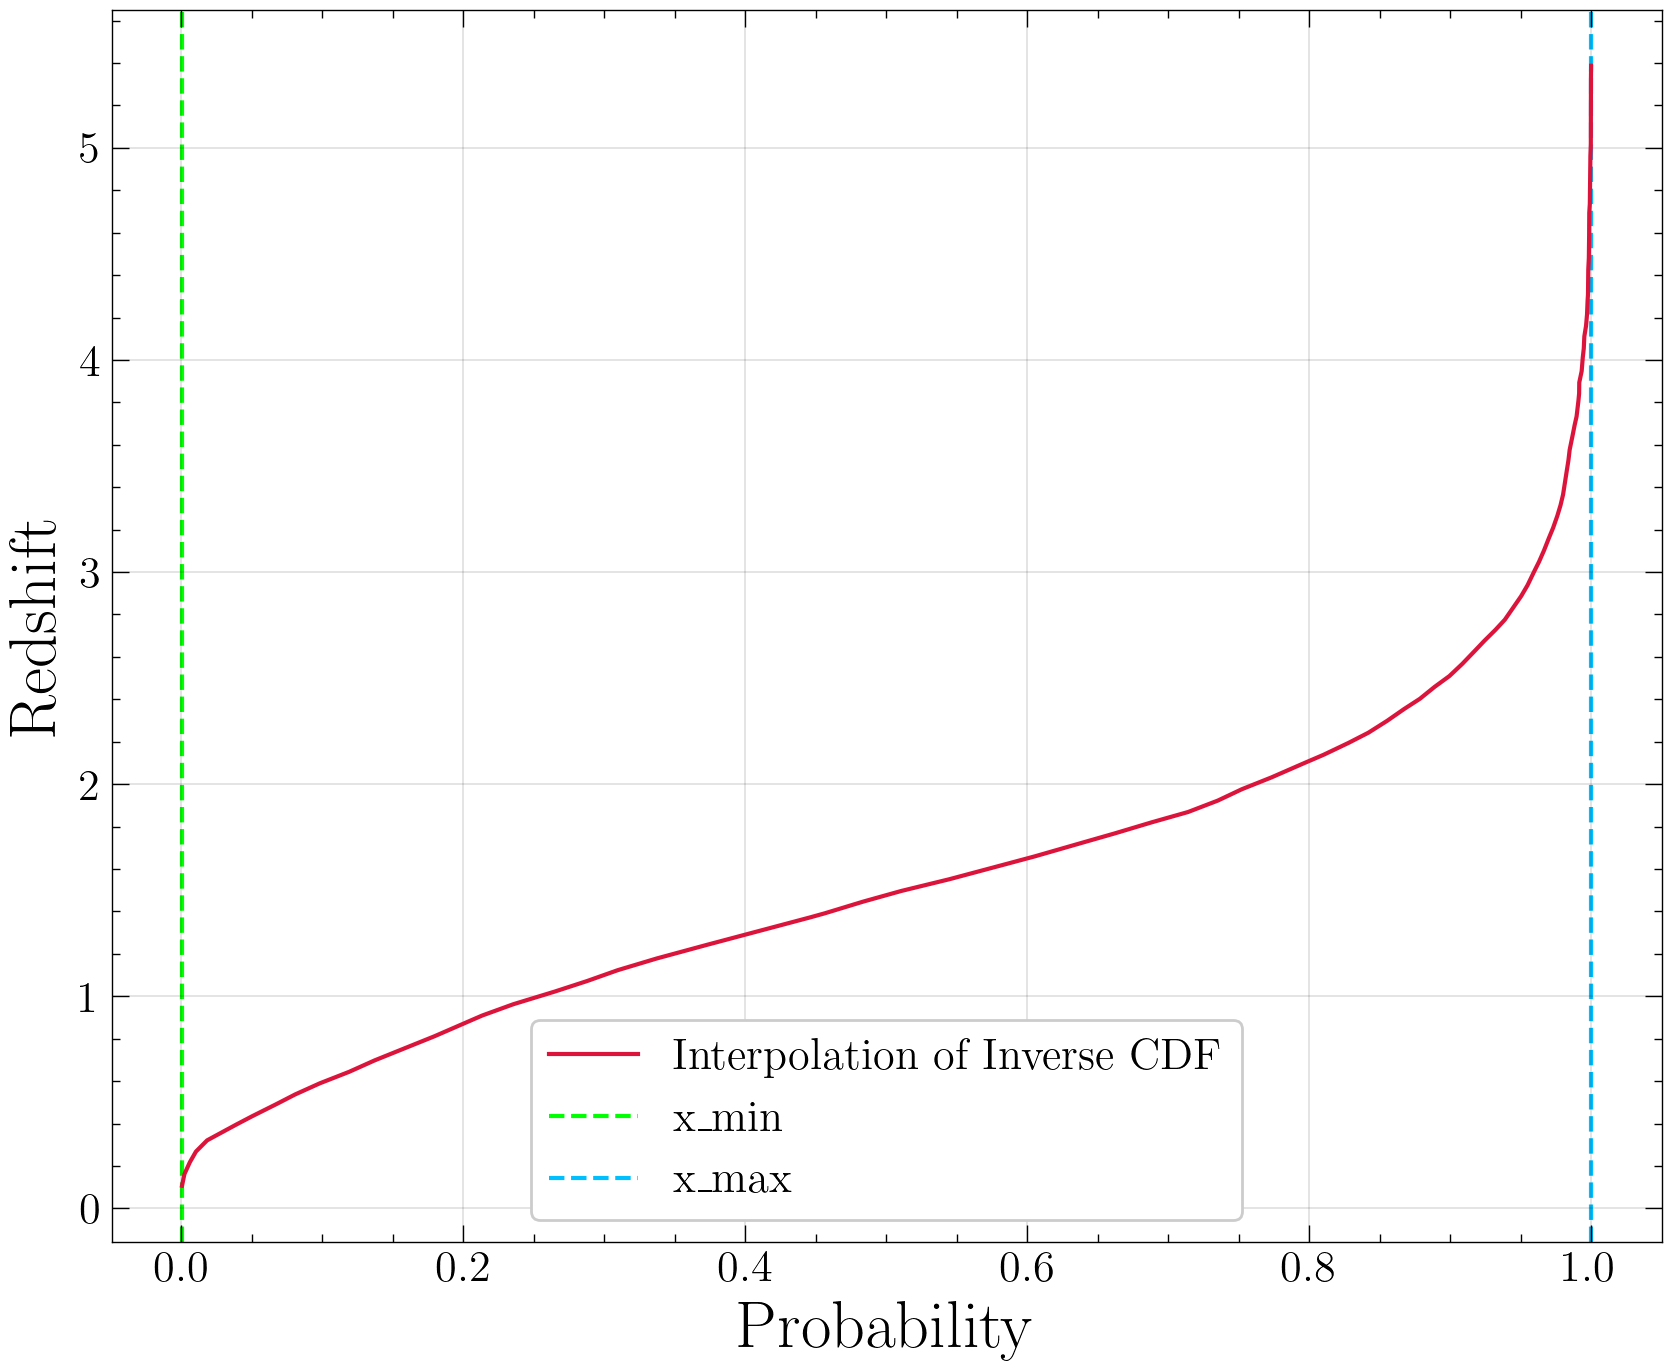

In [9]:
#If you want to use interp1d(x, y, kind='cubic'), then you need to remove the duplicate values in the x-array, i.e. the y-array of the CDF.
#pdf_values, indices = np.unique(pdf_values, return_index=True)
#bin_centres = bin_centres[indices]
x_min = np.min(pdf_values)
x_max = np.max(pdf_values)
print('x_min =', x_min)
print('x_max =', x_max)

InverseCDF = scipy.interpolate.interp1d(x=pdf_values, y=bin_centres)
x_dense = np.linspace(x_min, x_max, 10000)
plt.plot(x_dense, InverseCDF(x_dense), color='crimson', label='Interpolation of Inverse CDF')
plt.axvline(x_min, ls='--', color='lime', label='x_min', zorder=0)
plt.axvline(x_max, ls='--', color='deepskyblue', label='x_max', zorder=0)
plt.xlabel('Probability')
plt.ylabel('Redshift')
plt.legend()

Apply the inverse function sampling technique

In [10]:
x = np.random.uniform(x_min, x_max, N)
new_data_inverse = InverseCDF(x)

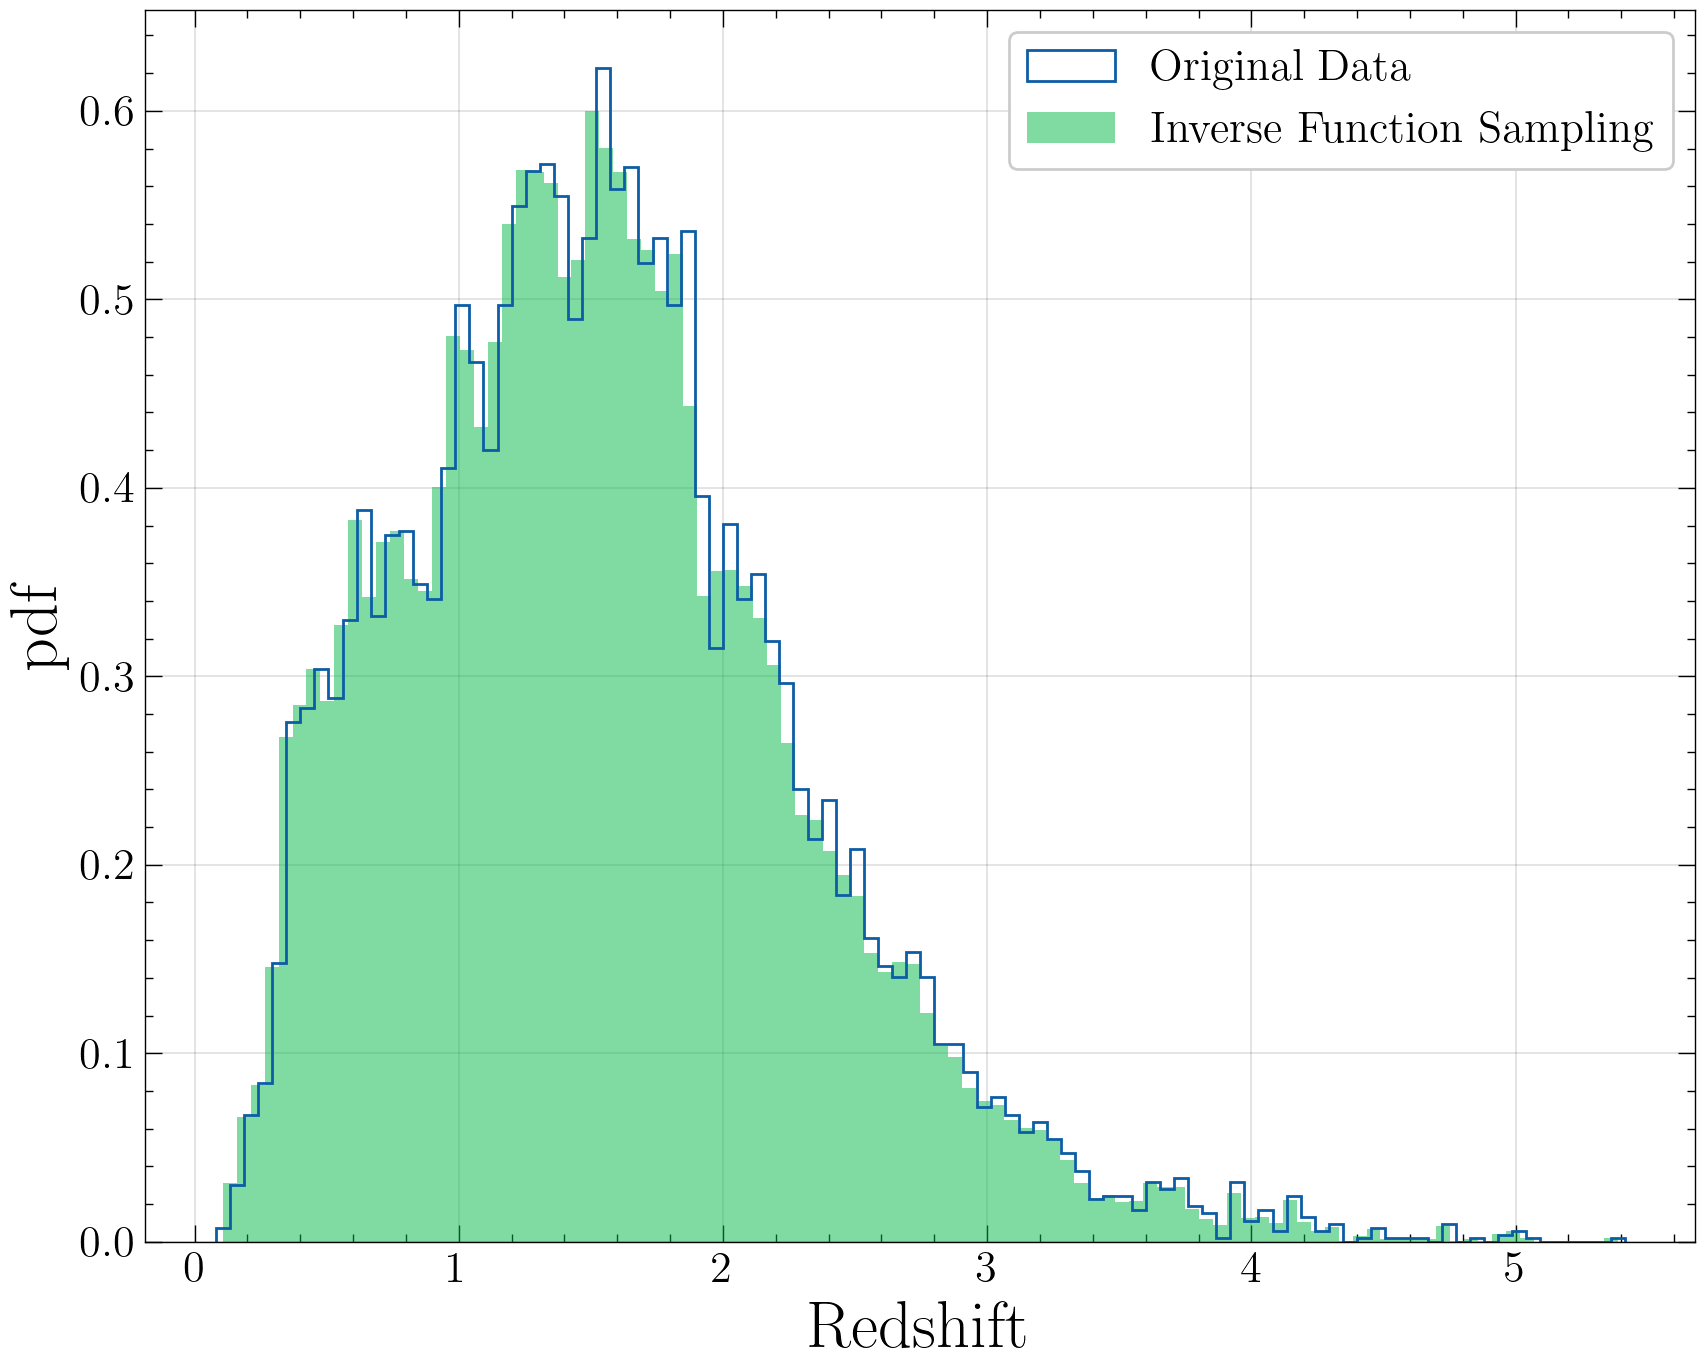

In [11]:
plt.hist(data, bins=100, density=True, histtype='step', label='Original Data');
#plt.hist(new_data_rejection, bins=100, density=True, histtype='step', label='Rejection Sampling');
plt.hist(new_data_inverse, bins=100, density=True, alpha=0.5, label='Inverse Function Sampling');
plt.xlabel('Redshift')
plt.ylabel('pdf')
plt.legend()

The offset between the original and the resampled distributions decreases if we increase the number of bins on which we perform the interpolation.

## 3) Quasars Distribution

The differential comoving volume per redshift per steradian at each input redshift is:

In [12]:
z_dense = np.linspace(0, 5, 1000)
astropy.cosmology.Planck18.differential_comoving_volume(z_dense)

<Quantity [0.00000000e+00, 2.16891070e+06, 8.63494579e+06, 1.93371118e+07,
           3.42144968e+07, 5.32062849e+07, 7.62517715e+07, 1.03290377e+08,
           1.34261662e+08, 1.69105341e+08, 2.07761293e+08, 2.50169580e+08,
           2.96270458e+08, 3.46004388e+08, 3.99312051e+08, 4.56134360e+08,
           5.16412471e+08, 5.80087795e+08, 6.47102010e+08, 7.17397073e+08,
           7.90915229e+08, 8.67599023e+08, 9.47391310e+08, 1.03023527e+09,
           1.11607439e+09, 1.20485254e+09, 1.29651390e+09, 1.39100301e+09,
           1.48826480e+09, 1.58824456e+09, 1.69088795e+09, 1.79614105e+09,
           1.90395031e+09, 2.01426259e+09, 2.12702518e+09, 2.24218576e+09,
           2.35969245e+09, 2.47949381e+09, 2.60153882e+09, 2.72577691e+09,
           2.85215794e+09, 2.98063226e+09, 3.11115063e+09, 3.24366430e+09,
           3.37812498e+09, 3.51448485e+09, 3.65269656e+09, 3.79271323e+09,
           3.93448847e+09, 4.07797637e+09, 4.22313150e+09, 4.36990891e+09,
           4.51826416e+09

The differential comoving volume per redshift at each input redshift is:

In [13]:
func = (4.*np.pi*astropy.units.sr) * astropy.cosmology.Planck18.differential_comoving_volume(z_dense)
func


<Quantity [0.00000000e+00, 2.72553356e+07, 1.08509929e+08, 2.42997314e+08,
           4.29952047e+08, 6.68609895e+08, 9.58208021e+08, 1.29798516e+09,
           1.68718181e+09, 2.12504038e+09, 2.61080540e+09, 3.14372366e+09,
           3.72304438e+09, 4.34801938e+09, 5.01790323e+09, 5.73195342e+09,
           6.48943050e+09, 7.28959822e+09, 8.13172368e+09, 9.01507749e+09,
           9.93893389e+09, 1.09025709e+10, 1.19052703e+10, 1.29463182e+10,
           1.40250045e+10, 1.51406236e+10, 1.62924741e+10, 1.74798594e+10,
           1.87020871e+10, 1.99584698e+10, 2.12483247e+10, 2.25709741e+10,
           2.39257452e+10, 2.53119702e+10, 2.67289867e+10, 2.81761372e+10,
           2.96527699e+10, 3.11582382e+10, 3.26919010e+10, 3.42531228e+10,
           3.58412738e+10, 3.74557296e+10, 3.90958718e+10, 4.07610877e+10,
           4.24507705e+10, 4.41643192e+10, 4.59011387e+10, 4.76606401e+10,
           4.94422403e+10, 5.12453624e+10, 5.30694355e+10, 5.49138949e+10,
           5.67781820e+10

Let's try to model the data with a uniform distribution:

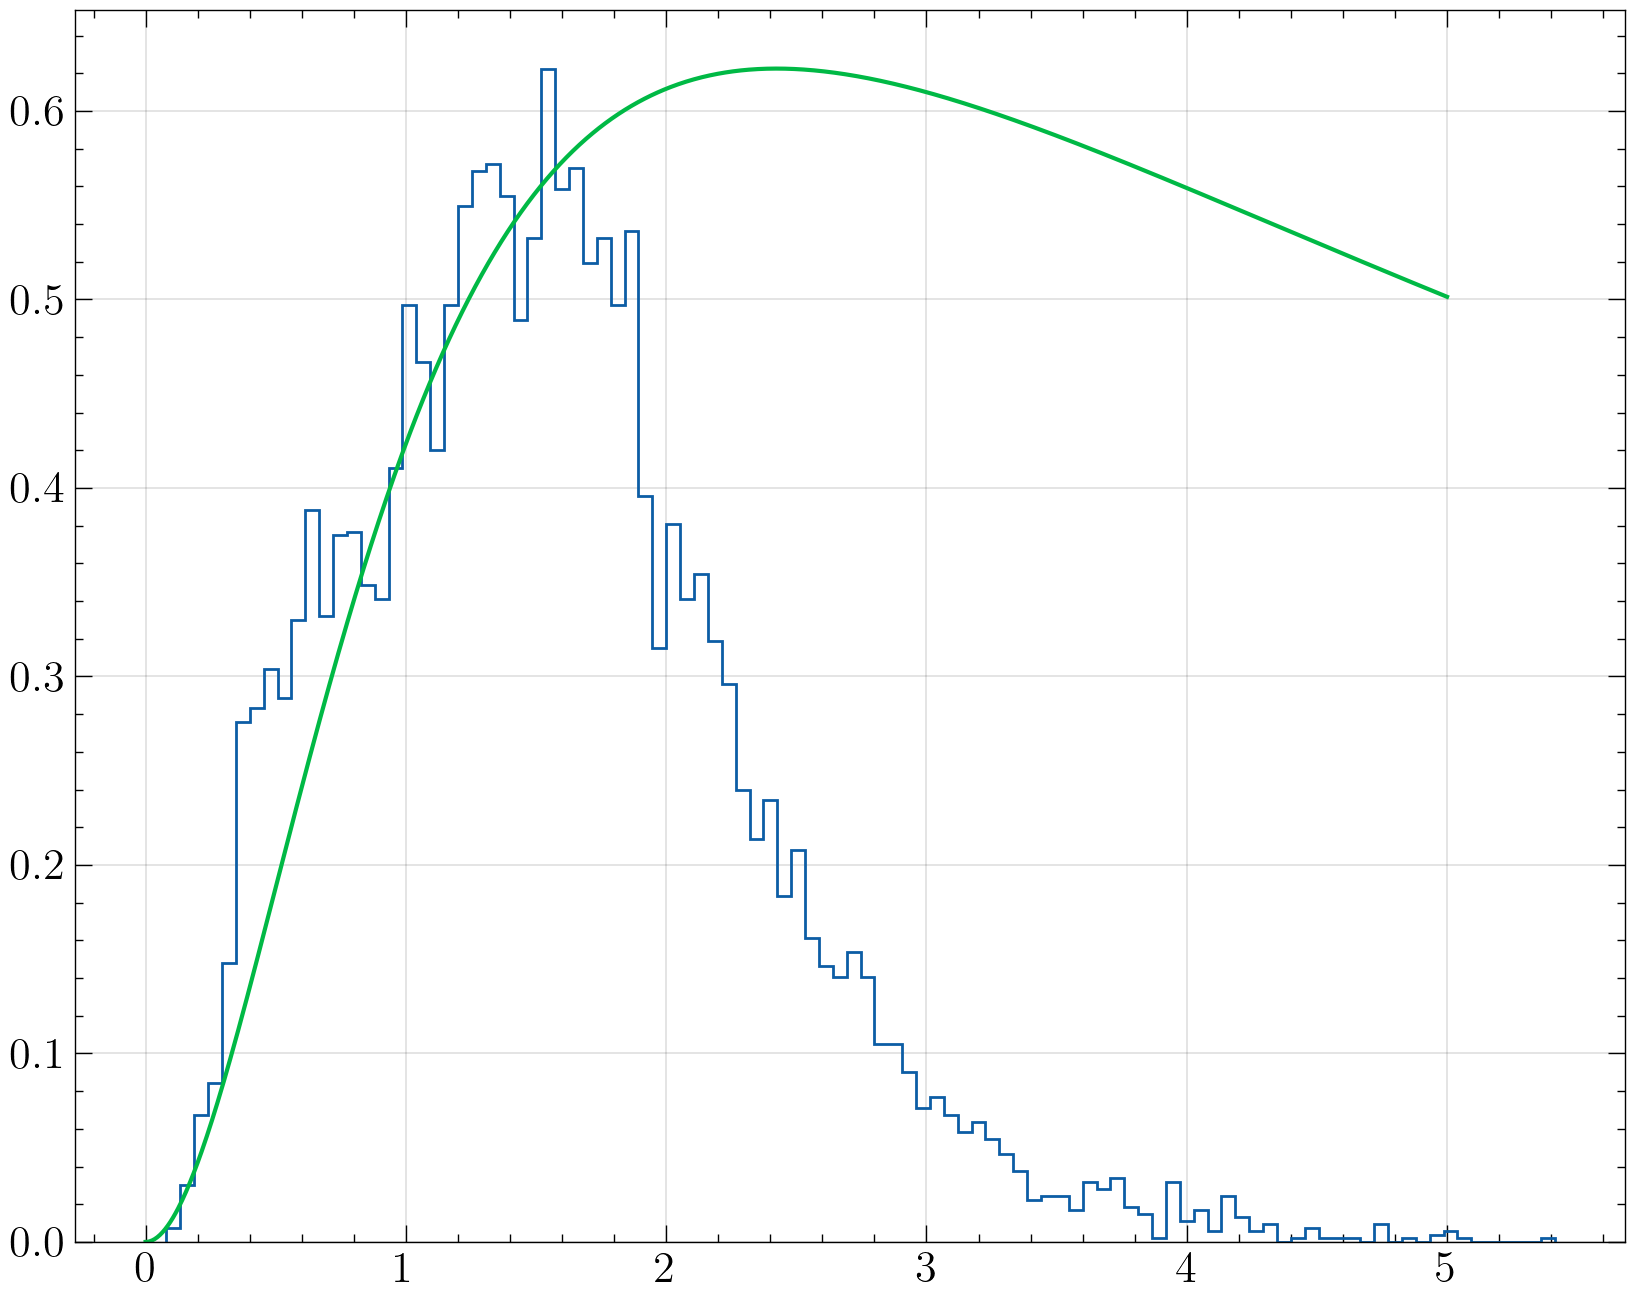

In [14]:
pdf_values, bins = plt.hist(data, bins=100, density=True, histtype='step')[:-1]
plt.plot(z_dense, func*(np.max(pdf_values)/np.max(func)))

The distribution of quasars is uniform only at low redshifts.